<h1 style="color: white; background-color: Dark Blue; font-family: 'Arial'; font-size: 36px; text-align: center; padding: 10px;">🚀 Psychometric Sigmoid Fitting ⚙️

### 📤 Importing Libraries 📤

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.multitest as multi
import seaborn as sns
import scipy.stats as stats
from scipy.optimize import curve_fit
from statsmodels.formula.api import ols
from scipy.stats import shapiro
from scipy.stats import friedmanchisquare
from scipy.stats import wilcoxon
from matplotlib.lines import Line2D
from scipy.stats import mannwhitneyu

### 📂 Loading the dataset 📂

In [2]:
sub = pd.read_csv('../Data/data.csv')
sub_info = pd.read_csv('../Data/subjectinfo.csv')
sub

,trialKeys,levelFreq,levelFace,lCueName,rCueName,srespLoc,srespChoice,RT,Hand,blockType,subjectId
0,AbHa,LF,1,Hasan,Abbas,right,Abbas,0.672450,Left,same,sub1
1,MahGol,LF,3,Goli,Mahnaz,right,Mahnaz,2.157862,Left,same,sub1
2,AbHa,LF,-3,Hasan,Abbas,right,Abbas,1.110335,Left,same,sub1
3,AbHa,LF,0,Hasan,Abbas,right,Abbas,0.676922,Left,same,sub1
4,MahGol,LF,0,Goli,Mahnaz,right,Mahnaz,0.970347,Left,same,sub1
...,...,...,...,...,...,...,...,...,...,...,...
51067,MahGol,LF,-1,Mahnaz,Goli,left,Mahnaz,1.531718,Right,mix,sub38
51068,AbHa,HF,-1,Abbas,Hasan,right,Hasan,0.985676,Right,mix,sub38
51069,AbHa,IF,-2,Abbas,Hasan,left,Abbas,1.299862,Right,mix,sub38
51070,MahGol,IF,-3,Mahnaz,Goli,left,Mahnaz,2.106708,Right,mix,sub38


In [3]:
sub_info.head()

,age,sex,dom
0,25,M,R
1,24,M,R
2,24,M,R
3,24,M,R
4,24,M,R


### 🔄 Preprocessing the Data 🔄

In [4]:
sub_info['subjectId'] = [f'sub{i + 1}' for i in range(len(sub_info))]
sub_info.head()

,age,sex,dom,subjectId
0,25,M,R,sub1
1,24,M,R,sub2
2,24,M,R,sub3
3,24,M,R,sub4
4,24,M,R,sub5


In [5]:
subject_main = []
subject = []
for i in range(0, 39):
    if i == 0:
        subject_main.append(None)
        subject.append(None)
        continue
    subject_main.append((sub[sub['subjectId'] == f'sub{i}']))
    subject.append(subject_main[i][subject_main[i]['blockType'] != 'mix'])
subject[1]

,trialKeys,levelFreq,levelFace,lCueName,rCueName,srespLoc,srespChoice,RT,Hand,blockType,subjectId
0,AbHa,LF,1,Hasan,Abbas,right,Abbas,0.672450,Left,same,sub1
1,MahGol,LF,3,Goli,Mahnaz,right,Mahnaz,2.157862,Left,same,sub1
2,AbHa,LF,-3,Hasan,Abbas,right,Abbas,1.110335,Left,same,sub1
3,AbHa,LF,0,Hasan,Abbas,right,Abbas,0.676922,Left,same,sub1
4,MahGol,LF,0,Goli,Mahnaz,right,Mahnaz,0.970347,Left,same,sub1
...,...,...,...,...,...,...,...,...,...,...,...
667,MahGol,IF,-2,Goli,Mahnaz,right,Mahnaz,0.152957,Right,same,sub1
668,AbHa,IF,0,Hasan,Abbas,right,Abbas,0.368017,Right,same,sub1
669,AbHa,IF,1,Hasan,Abbas,left,Hasan,0.559337,Right,same,sub1
670,AbHa,IF,-2,Hasan,Abbas,right,Abbas,0.596477,Right,same,sub1


###  🤖 Function Creations 🤖 

## 👨🏻‍💻 Ploting and Getting the Beta Values 📊

In [6]:
def sigmoid(x, alpha, beta):
    return alpha / (1 + np.exp(-beta * x))
def fit_sigmoid(data, pair, freq):
    data_filtered = data[
        (data['trialKeys'] == pair) & 
        (data['levelFreq'] == freq)
    ]
    cog_prob = data_filtered.groupby(['levelFace', 'srespChoice']).size().unstack(fill_value=0)
    if pair == 'AbHa':
        cog_prob['probability'] = cog_prob.get('Hasan', 0) / (cog_prob.get('Hasan', 0) + cog_prob.get('Abbas', 0))
    elif pair == 'MahGol':
        cog_prob['probability'] = cog_prob.get('Goli', 0) / (cog_prob.get('Goli', 0) + cog_prob.get('Mahnaz', 0))
    else:
        raise ValueError("pair must be 'AbHa' or 'MahGol'")
    x_data = cog_prob.index.values
    y_data = cog_prob['probability'].values
    starter_guess = [1.0, 1.0]
    try:
        params, _ = curve_fit(sigmoid, x_data, y_data, p0=starter_guess, maxfev=100)
        alpha, beta = params
        return x_data, y_data, alpha, beta
    except RuntimeError:
        return x_data, y_data, np.nan, np.nan

In [7]:
betas = []
for i in range(1, len(subject)):
    subj_data = subject[i]
    subj_row = {'subject_id': f"sub{i}"}
    for pair in ['AbHa', 'MahGol']:
        for freq in ['LF', 'HF', 'IF']:
            x, y, alpha, beta = fit_sigmoid(subj_data, pair, freq)
            key = f"{freq.lower()}_{pair.lower()}"
            subj_row[key] = beta
    subj_row['sex'] = sub_info.iloc[i-1]['sex']
    betas.append(subj_row)
beta_df = pd.DataFrame(betas)

In [8]:
beta_df.to_csv('betas.csv')

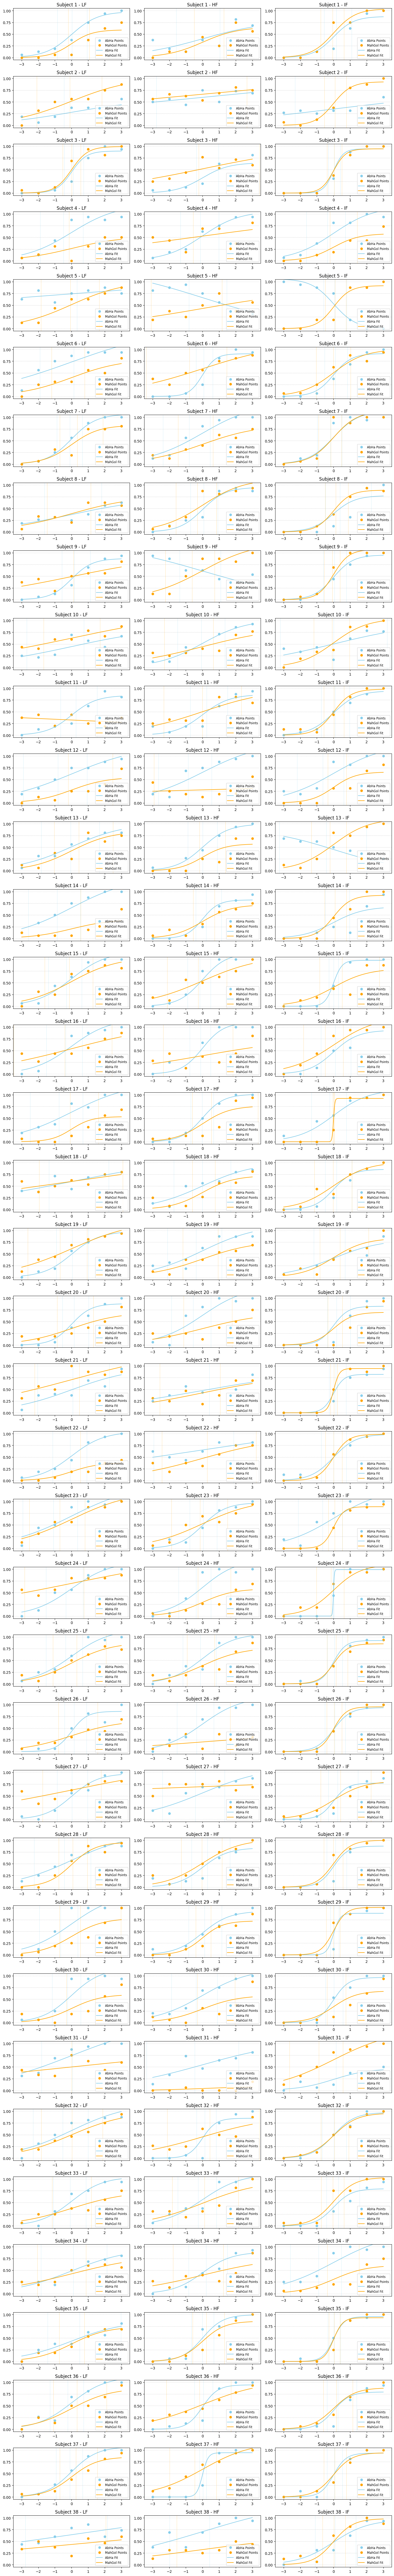

In [9]:
def find_x_for_y(y_target, alpha, beta):
    if y_target >= alpha or y_target <= 0:
        return None
    return -np.log((alpha / y_target) - 1) / beta
fig, axs = plt.subplots(len(subject)-1, 3, figsize=(15, len(subject)*2.5))
x_line = np.linspace(-3, 3, 200)
y_levels = [0.25, 0.5, 0.75]
for i in range(1, len(subject)):
    subj_data = subject[i]
    for j, freq in enumerate(['LF', 'HF', 'IF']):
        x_abha, y_abha, a_abha, b_abha = fit_sigmoid(subj_data, 'AbHa', freq)
        x_mahgol, y_mahgol, a_mahgol, b_mahgol = fit_sigmoid(subj_data, 'MahGol', freq)
        ax = axs[i-1, j]
        scatter_abha = ax.scatter(x_abha, y_abha, color='skyblue', label='AbHa Points')
        scatter_mahgol = ax.scatter(x_mahgol, y_mahgol, color='orange', label='MahGol Points')
        lines = []
        labels = []
        if not np.isnan(b_abha):
            line_abha, = ax.plot(x_line, sigmoid(x_line, a_abha, b_abha), color='skyblue', linestyle='-', label='AbHa Fit')
            lines.append(line_abha)
            labels.append('AbHa Fit')
            for y_val in y_levels:
                x_val = find_x_for_y(y_val, a_abha, b_abha)
                if x_val is not None and -3.5 < x_val < 3.5:
                    ax.axvline(x_val, color='skyblue', linestyle='--', linewidth=0.5, alpha=0.7)
        if not np.isnan(b_mahgol):
            line_mahgol, = ax.plot(x_line, sigmoid(x_line, a_mahgol, b_mahgol), color='orange', linestyle='-', label='MahGol Fit')
            lines.append(line_mahgol)
            labels.append('MahGol Fit')
            for y_val in y_levels:
                x_val = find_x_for_y(y_val, a_mahgol, b_mahgol)
                if x_val is not None and -3.5 < x_val < 3.5:
                    ax.axvline(x_val, color='orange', linestyle='--', linewidth=0.5, alpha=0.7)
        for ytick in [0.0, *y_levels, 1.0]:
            ax.axhline(ytick, color='gray', linestyle='--', linewidth=0.4 if ytick in [0, 1] else 0.5, alpha=0.5)
        ax.set_title(f"Subject {i} - {freq}")
        ax.set_ylim(-0.05, 1.05)
        ax.set_xlim(-3.5, 3.5)
        ax.set_xticks(range(-3, 4))
        ax.set_yticks([0.0, *y_levels, 1.0])
        custom_lines = [
            Line2D([0], [0], color='skyblue', marker='o', linestyle='None', label='AbHa Points'),
            Line2D([0], [0], color='orange', marker='o', linestyle='None', label='MahGol Points'),
        ]
        if not np.isnan(b_abha):
            custom_lines.append(Line2D([0], [0], color='skyblue', linestyle='-', label='AbHa Fit'))
        if not np.isnan(b_mahgol):
            custom_lines.append(Line2D([0], [0], color='orange', linestyle='-', label='MahGol Fit'))
        ax.legend(handles=custom_lines, loc='lower right', fontsize='small')
plt.tight_layout()
plt.show()

### 📉 Statistical view for our data 📈

In [10]:
beta = beta_df.copy()
df_abha = beta[['subject_id', 'sex', 'lf_abha', 'hf_abha', 'if_abha']]
df_abha = df_abha.melt(id_vars=['subject_id', 'sex'], var_name='frequency', value_name='beta')
df_abha['frequency'] = df_abha['frequency'].str.replace('_abha', '')
df_abha['spectrum'] = 'AbHa'
df_mahgol = beta[['subject_id', 'sex', 'lf_mahgol', 'hf_mahgol', 'if_mahgol']]
df_mahgol = df_mahgol.melt(id_vars=['subject_id', 'sex'], var_name='frequency', value_name='beta')
df_mahgol['frequency'] = df_mahgol['frequency'].str.replace('_mahgol', '')
df_mahgol['spectrum'] = 'MahGol'
df_abha

,subject_id,sex,frequency,beta,spectrum
0,sub1,M,lf,1.257900,AbHa
1,sub2,M,lf,0.439934,AbHa
2,sub3,M,lf,2.225395,AbHa
3,sub4,M,lf,0.714395,AbHa
4,sub5,M,lf,0.072655,AbHa
...,...,...,...,...,...
109,sub34,M,if,0.562783,AbHa
110,sub35,F,if,3.011250,AbHa
111,sub36,F,if,2.020329,AbHa
112,sub37,F,if,2.596151,AbHa


### -Testing for Normal distrubution of our data

In [11]:
def normal_dis_test(df):
    for freq in df['frequency'].unique():
        beta_values = df[df['frequency'] == freq]['beta']
        stat, p = shapiro(beta_values)
        print(f'Shapiro-Wilk test for frequency = {freq}: p-value = {p:.3f}')

In [12]:
normal_dis_test(df_abha)

Shapiro-Wilk test for frequency = lf: p-value = 0.022
Shapiro-Wilk test for frequency = hf: p-value = 0.000
Shapiro-Wilk test for frequency = if: p-value = 0.000


In [13]:
normal_dis_test(df_mahgol)

Shapiro-Wilk test for frequency = lf: p-value = 0.155
Shapiro-Wilk test for frequency = hf: p-value = 0.068
Shapiro-Wilk test for frequency = if: p-value = 0.000


in almost all we reject the null hypothesis(That they are normalyl distrubuted) or the p value is not high enough to interprate them as a normal distrubution.

In [14]:
abha_pivot = df_abha.pivot(index='subject_id', columns='frequency', values='beta')
mahgol_pivot = df_mahgol.pivot(index='subject_id', columns=['frequency'], values='beta')

In [15]:
stat, p_value_abha = friedmanchisquare(abha_pivot['lf'], abha_pivot['if'], abha_pivot['hf'])
stat, p_value_mahgol = friedmanchisquare(mahgol_pivot['lf'], mahgol_pivot['if'], mahgol_pivot['hf'])
results_df = pd.DataFrame({  
    'Group': ['AbHa', 'MahGol'],  
    'p-value': [p_value_abha, p_value_mahgol]  
})  
print(results_df)

    Group       p-value
0    AbHa  1.503439e-03
1  MahGol  1.110487e-10


In [16]:
abha_pivot = abha_pivot.copy()
mahgol_pivot = mahgol_pivot.copy()
abha_pivot['id'] = abha_pivot.index
mahgol_pivot['id'] = mahgol_pivot.index
abha_long = pd.melt(abha_pivot, id_vars='id', value_vars=['hf', 'if', 'lf'],
                    var_name='feature', value_name='value')
abha_long['group'] = 'abha'
mahgol_long = pd.melt(mahgol_pivot, id_vars='id', value_vars=['hf', 'if', 'lf'],
                      var_name='feature', value_name='value')
mahgol_long['group'] = 'mahgol'
combined_long = pd.concat([abha_long, mahgol_long])

C:\Users\Public\Documents\iSkysoft\CreatorTemp\ipykernel_22136\1002179225.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=combined_long, x='feature', y='value', hue='group',


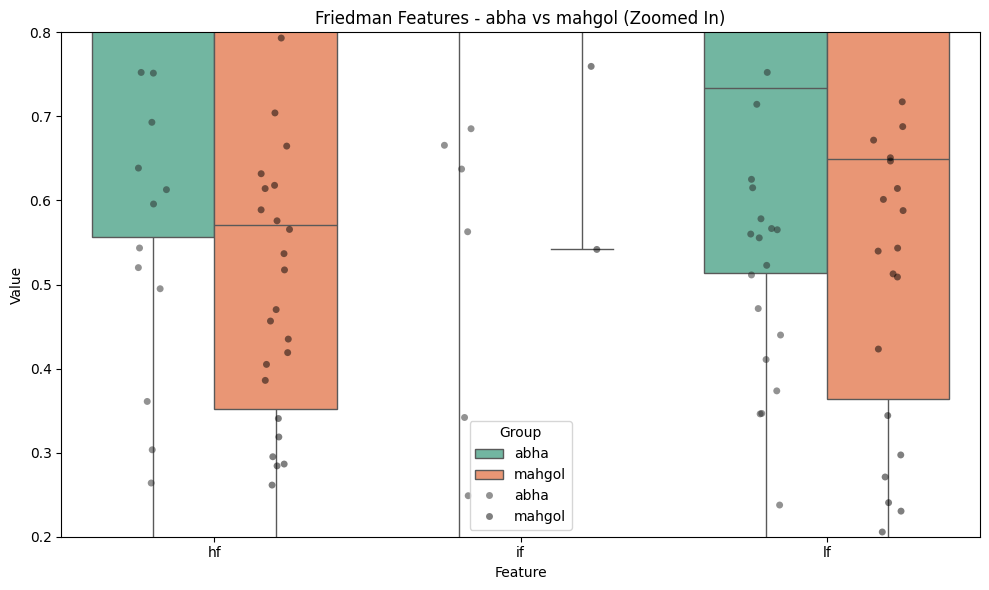

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_long, x='feature', y='value', hue='group', palette='Set2', showfliers=False)
sns.stripplot(data=combined_long, x='feature', y='value', hue='group',
              dodge=True, jitter=True, color='black', alpha=0.5)
plt.ylim(0.2, 0.8)
plt.title('Friedman Features - abha vs mahgol (Zoomed In)')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.legend(title='Group')
plt.tight_layout()
plt.show()

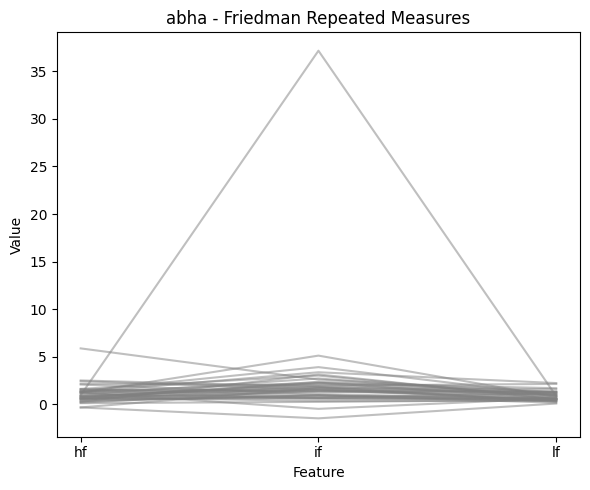

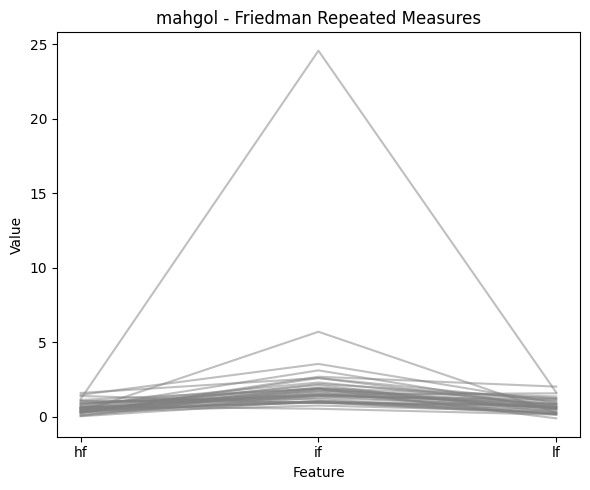

In [18]:
def plot_spaghetti(df_long, group_name):
    plt.figure(figsize=(6, 5))
    for i in df_long['id'].unique():
        sub = df_long[df_long['id'] == i]
        plt.plot(sub['feature'], sub['value'], color='gray', alpha=0.5)
    plt.title(f'{group_name} - Friedman Repeated Measures')
    plt.ylabel('Value')
    plt.xlabel('Feature')
    plt.tight_layout()
    plt.show()
plot_spaghetti(abha_long, 'abha')
plot_spaghetti(mahgol_long, 'mahgol')

Extremley low so we reject the null hypothesis(there is a significant difference between the spatial frequenceis)

In [19]:
abha_pivot = abha_pivot.sort_index(key=lambda x: x.str.extract('(\d+)').astype(int)[0])
mahgol_pivot = mahgol_pivot.sort_index(key=lambda x: x.str.extract('(\d+)').astype(int)[0])

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Public\Documents\iSkysoft\CreatorTemp\ipykernel_22136\3438150772.py:1: SyntaxWarning: invalid escape sequence '\d'
  abha_pivot = abha_pivot.sort_index(key=lambda x: x.str.extract('(\d+)').astype(int)[0])
C:\Users\Public\Documents\iSkysoft\CreatorTemp\ipykernel_22136\3438150772.py:2: SyntaxWarning: invalid escape sequence '\d'
  mahgol_pivot = mahgol_pivot.sort_index(key=lambda x: x.str.extract('(\d+)').astype(int)[0])


In [20]:
abha_pivot = abha_pivot.reset_index()
abha_pivot.head()

frequency,subject_id,hf,if,lf,id
0,sub1,0.494979,1.626379,1.257900,sub1
1,sub2,0.116916,0.248786,0.439934,sub2
2,sub3,1.253312,3.362084,2.225395,sub3
3,sub4,0.890222,0.803847,0.714395,sub4
4,sub5,-0.338142,-1.482466,0.072655,sub5


In [21]:
mahgol_pivot = mahgol_pivot.reset_index()
mahgol_pivot.head()

frequency,subject_id,hf,if,lf,id
0,sub1,0.934382,1.490587,1.579954,sub1
1,sub2,0.099433,1.838069,0.543332,sub2
2,sub3,0.284256,2.692808,2.028974,sub3
3,sub4,0.182288,1.287155,0.646910,sub4
4,sub5,0.286452,1.973270,0.614266,sub5


In [22]:
abha_pivot = abha_pivot.rename(columns={'subject_id': 'subjectId'}) 
mahgol_pivot = mahgol_pivot.rename(columns={'subject_id': 'subjectId'}) 

In [23]:
abha = abha_pivot.merge(sub_info[['subjectId', 'sex']], on = 'subjectId', how='left')

In [24]:
mahgol = mahgol_pivot.merge(sub_info[['subjectId', 'sex']], on = 'subjectId', how='left')

In [25]:
abha.head()

,subjectId,hf,if,lf,id,sex
0,sub1,0.494979,1.626379,1.257900,sub1,M
1,sub2,0.116916,0.248786,0.439934,sub2,M
2,sub3,1.253312,3.362084,2.225395,sub3,M
3,sub4,0.890222,0.803847,0.714395,sub4,M
4,sub5,-0.338142,-1.482466,0.072655,sub5,M


In [26]:
mahgol.head()

,subjectId,hf,if,lf,id,sex
0,sub1,0.934382,1.490587,1.579954,sub1,M
1,sub2,0.099433,1.838069,0.543332,sub2,M
2,sub3,0.284256,2.692808,2.028974,sub3,M
3,sub4,0.182288,1.287155,0.646910,sub4,M
4,sub5,0.286452,1.973270,0.614266,sub5,M


wether they differ from each other

In [27]:
hf_if = wilcoxon(abha['hf'], abha['if'])
hf_lf = wilcoxon(abha['hf'], abha['lf'])
if_lf = wilcoxon(abha['if'], abha['lf'])
print('For AbHa:')
print("HF vs IF:", hf_if.pvalue)
print("HF vs LF:", hf_lf.pvalue)
print("IF vs LF:", if_lf.pvalue)
print("Medians, which one is more sensetive:\n", abha[['hf', 'if', 'lf']].median())

For AbHa:
HF vs IF: 0.014845291603705846
HF vs LF: 0.2674894785377546
IF vs LF: 2.060829137917608e-05
Medians, which one is more sensetive:
 hf    0.917808
if    1.588989
lf    0.733364
dtype: float64


In [28]:
hf_if_ = wilcoxon(mahgol['hf'], mahgol['if'])
hf_lf_ = wilcoxon(mahgol['hf'], mahgol['lf'])
if_lf_ = wilcoxon(mahgol['if'], mahgol['lf'])
print('For MahGol:')
print("HF vs IF:", hf_if_.pvalue)
print("HF vs LF:", hf_lf_.pvalue)
print("IF vs LF:", if_lf_.pvalue)
print("Medians, which one is more sensetive:\n", mahgol[['hf', 'if', 'lf']].median())

For MahGol:
HF vs IF: 4.001776687800884e-10
HF vs LF: 0.3279708704649238
IF vs LF: 1.4551915228366852e-11
Medians, which one is more sensetive:
 hf    0.570674
if    1.594894
lf    0.648854
dtype: float64


In [29]:
abha_ = abha[['hf', 'if', 'lf']].copy()
mahgol_ = mahgol[['hf', 'if', 'lf']].copy()
abha_['id'] = abha_.index
mahgol_['id'] = mahgol_.index
def melt_features(df, label):
    long_df = pd.melt(df, id_vars='id', value_vars=['hf', 'if', 'lf'],
                      var_name='feature', value_name='value')
    long_df['group'] = label
    return long_df
abha_long = melt_features(abha_, 'abha')
mahgol_long = melt_features(mahgol_, 'mahgol')
combined_long = pd.concat([abha_long, mahgol_long])

C:\Users\Public\Documents\iSkysoft\CreatorTemp\ipykernel_22136\2397569656.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=combined_long, x='feature', y='value', hue='group',


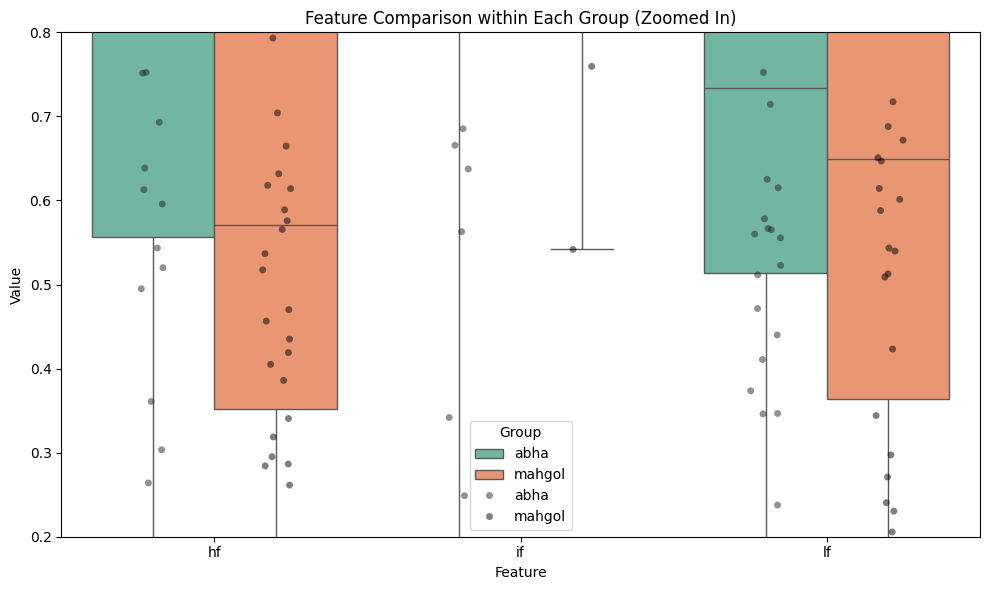

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_long, x='feature', y='value', hue='group', palette='Set2', showfliers=False)
sns.stripplot(data=combined_long, x='feature', y='value', hue='group',
              dodge=True, jitter=True, color='black', alpha=0.5)
plt.ylim(0.2, 0.8)
plt.title('Feature Comparison within Each Group (Zoomed In)')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.legend(title='Group')
plt.tight_layout()
plt.show()

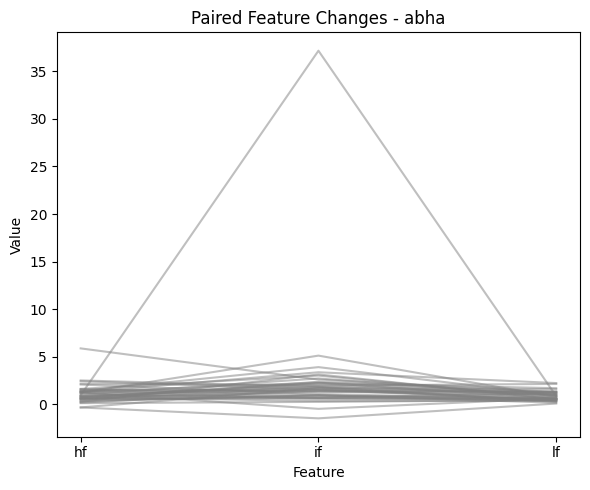

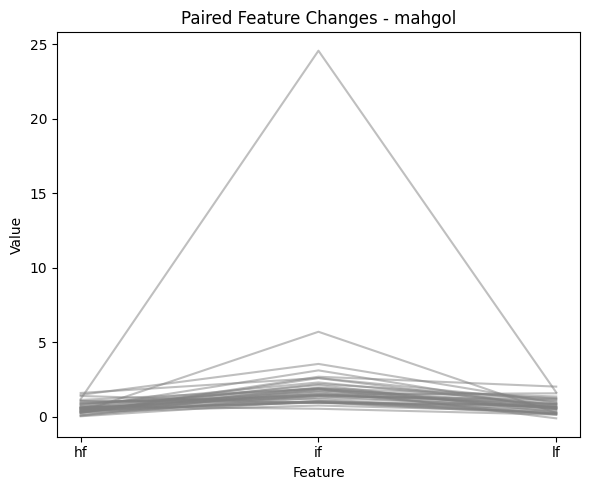

In [31]:
def spaghetti_by_feature(df_long, group_name):
    plt.figure(figsize=(6, 5))
    for i in df_long['id'].unique():
        sub = df_long[df_long['id'] == i]
        plt.plot(sub['feature'], sub['value'], color='gray', alpha=0.5)
    plt.title(f'Paired Feature Changes - {group_name}')
    plt.ylabel('Value')
    plt.xlabel('Feature')
    plt.tight_layout()
    plt.show()
spaghetti_by_feature(abha_long, 'abha')
spaghetti_by_feature(mahgol_long, 'mahgol')

whether they identifiy their own gender better or not

In [32]:
male_same_gen = abha[abha['sex'] == 'M']
male_op_gen = mahgol[mahgol['sex'] == 'M']
hf_= wilcoxon(male_same_gen['hf'], male_op_gen['hf'])
if_ = wilcoxon(male_same_gen['if'], male_op_gen['if'])
lf_ = wilcoxon(male_same_gen['lf'], male_op_gen['lf'])
print('For Male:')
print("hf_:", hf_.pvalue)
print("if_", if_.pvalue)
print("lf_", lf_.pvalue)

For Male:
hf_: 0.050537109375
if_ 0.243499755859375
lf_ 0.644134521484375


In [33]:
female_op_gen = abha[abha['sex'] == 'F']
female_same_gen = mahgol[mahgol['sex'] == 'F']
hf__= wilcoxon(female_op_gen['hf'], female_same_gen['hf'])
if__ = wilcoxon(female_op_gen['if'], female_same_gen['if'])
lf__ = wilcoxon(female_op_gen['lf'], female_same_gen['lf'])
print('For MahGol:')
print("hf_:", hf__.pvalue)
print("if_", if__.pvalue)
print("lf_", lf__.pvalue)

For MahGol:
hf_: 0.01531219482421875
if_ 0.956329345703125
lf_ 0.2305126190185547


In [34]:
def fit_sigmoid_allfreq(data, pair):
    data_filtered = data[data['trialKeys'] == pair]
    cog_prob = data_filtered.groupby(['levelFace', 'srespChoice']).size().unstack(fill_value=0)
    if pair == 'AbHa':
        cog_prob['probability'] = cog_prob.get('Hasan', 0) / (cog_prob.get('Hasan', 0) + cog_prob.get('Abbas', 0))
    elif pair == 'MahGol':
        cog_prob['probability'] = cog_prob.get('Goli', 0) / (cog_prob.get('Goli', 0) + cog_prob.get('Mahnaz', 0))
    else:
        raise ValueError("pair must be 'AbHa' or 'MahGol'")
    x_data = cog_prob.index.values
    y_data = cog_prob['probability'].values
    starter_guess = [1.0, 1.0]
    try:
        params, _ = curve_fit(sigmoid, x_data, y_data, p0=starter_guess, maxfev=100)
        _, beta = params
        return beta
    except RuntimeError:
        return np.nan
betas = []
for i in range(1, len(subject)):
    subj_data = subject[i]
    subj_row = {'subject_id': f"sub{i}"}
    subj_row['abha'] = fit_sigmoid_allfreq(subj_data, 'AbHa')
    subj_row['mahgol'] = fit_sigmoid_allfreq(subj_data, 'MahGol')
    subj_row['sex'] = sub_info.iloc[i-1]['sex']
    betas.append(subj_row)
beta_df = pd.DataFrame(betas)

In [35]:
beta_df.head()

,subject_id,abha,mahgol,sex
0,sub1,1.137710,1.316143,M
1,sub2,0.220283,0.481379,M
2,sub3,2.398223,1.085020,M
3,sub4,0.796341,0.518584,M
4,sub5,-0.295846,0.735381,M


In [36]:
all_freq = wilcoxon(beta_df[beta_df['sex'] == 'M']['abha'], beta_df[beta_df['sex'] == 'M']['mahgol'],)
print("All frequencies p value for male:", all_freq.pvalue)

All frequencies p value for male: 0.4585723876953125


In [37]:
all_freq = wilcoxon(beta_df[beta_df['sex'] == 'F']['abha'], beta_df[beta_df['sex'] == 'F']['mahgol'],)
print("All frequencies p value for female:", all_freq.pvalue)

All frequencies p value for female: 0.17685317993164062


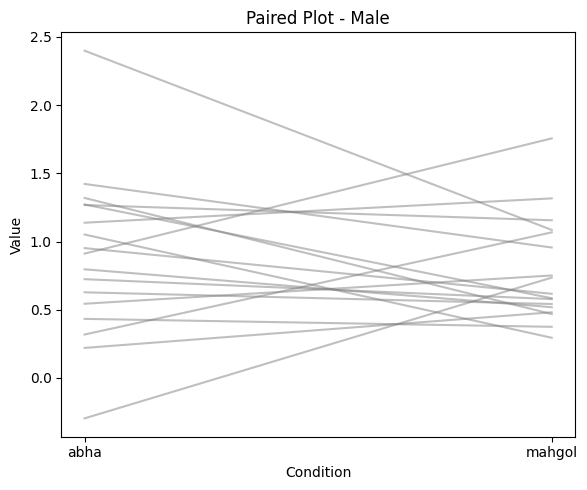

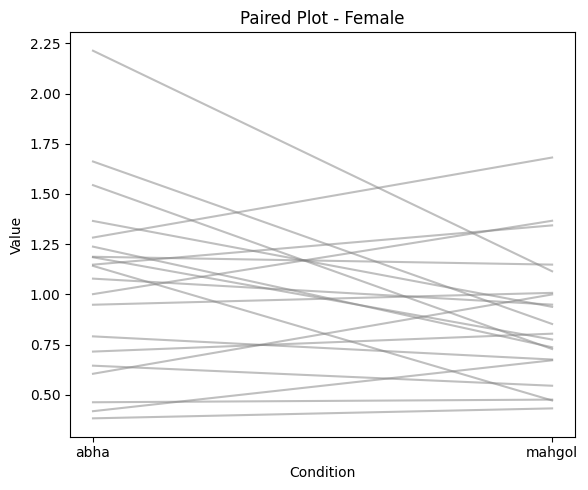

C:\Users\Public\Documents\iSkysoft\CreatorTemp\ipykernel_22136\1104970650.py:32: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(x='condition', y='value', hue='sex', data=combined_long,


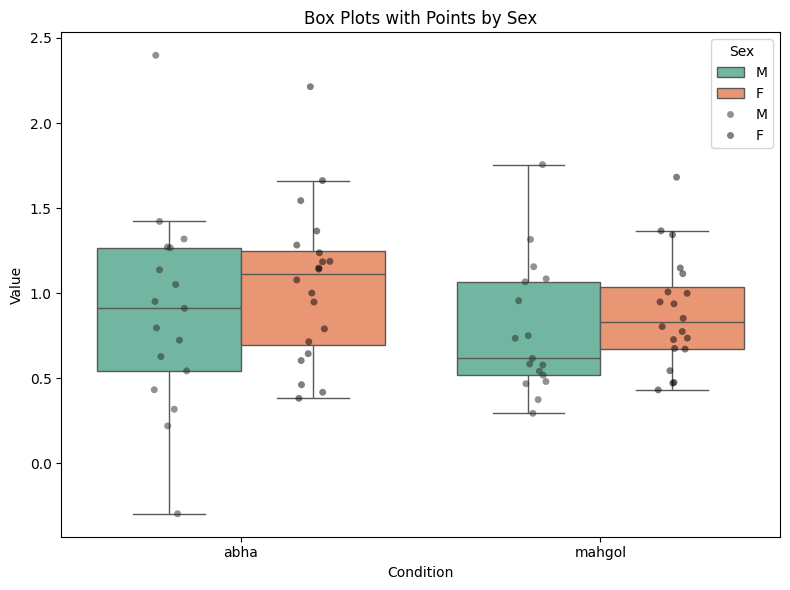

In [38]:
male_df = beta_df[beta_df['sex'] == 'M'][['abha', 'mahgol']].copy()
male_df['id'] = male_df.index
male_long = pd.melt(male_df, id_vars='id', value_vars=['abha', 'mahgol'],
                    var_name='condition', value_name='value')
male_long['sex'] = 'M'
female_df = beta_df[beta_df['sex'] == 'F'][['abha', 'mahgol']].copy()
female_df['id'] = female_df.index
female_long = pd.melt(female_df, id_vars='id', value_vars=['abha', 'mahgol'],
                      var_name='condition', value_name='value')
female_long['sex'] = 'F'
plt.figure(figsize=(6, 5))
for i in male_long['id'].unique():
    d = male_long[male_long['id'] == i]
    plt.plot(['abha', 'mahgol'], d['value'], color='gray', alpha=0.5)
plt.title('Paired Plot - Male')
plt.ylabel('Value')
plt.xlabel('Condition')
plt.tight_layout()
plt.show()
plt.figure(figsize=(6, 5))
for i in female_long['id'].unique():
    d = female_long[female_long['id'] == i]
    plt.plot(['abha', 'mahgol'], d['value'], color='gray', alpha=0.5)
plt.title('Paired Plot - Female')
plt.ylabel('Value')
plt.xlabel('Condition')
plt.tight_layout()
plt.show()
combined_long = pd.concat([male_long, female_long])
plt.figure(figsize=(8, 6))
sns.boxplot(x='condition', y='value', hue='sex', data=combined_long, palette='Set2', showfliers=False)
sns.stripplot(x='condition', y='value', hue='sex', data=combined_long,
              dodge=True, jitter=True, color='black', alpha=0.5)
plt.title('Box Plots with Points by Sex')
plt.ylabel('Value')
plt.xlabel('Condition')
plt.legend(title='Sex')
plt.tight_layout()
plt.show()

Hypothesis: Left hand

In [39]:
def fit_sigmoid_by_conditions(data, pair, hand, freq):
    data_filtered = data[
        (data['trialKeys'] == pair) &
        (data['Hand'] == hand) &
        (data['levelFreq'] == freq)
    ]
    cog_prob = data_filtered.groupby(['levelFace', 'srespChoice']).size().unstack(fill_value=0)
    if pair == 'AbHa':
        cog_prob['probability'] = cog_prob.get('Hasan', 0) / (cog_prob.get('Hasan', 0) + cog_prob.get('Abbas', 0))
    elif pair == 'MahGol':
        cog_prob['probability'] = cog_prob.get('Goli', 0) / (cog_prob.get('Goli', 0) + cog_prob.get('Mahnaz', 0))
    else:
        return np.nan
    x_data = cog_prob.index.values
    y_data = cog_prob['probability'].values
    starter_guess = [1.0, 1.0]
    try:
        params, _ = curve_fit(sigmoid, x_data, y_data, p0=starter_guess, maxfev=100)
        _, beta = params
        return beta
    except RuntimeError:
        return np.nan
betas = []
frequencies = ['LF', 'HF', 'IF']
pairs = ['AbHa', 'MahGol']
hands = ['Right', 'Left']
for i in range(1, len(subject)):
    subj_data = subject[i]
    subj_row = {'subject_id': f"sub{i}"}
    for freq in frequencies:
        for pair in pairs:
            for hand in hands:
                beta = fit_sigmoid_by_conditions(subj_data, pair, hand, freq)
                key = f"{freq.lower()}_{pair.lower()}_{hand.lower()}"
                subj_row[key] = beta
    subj_row['sex'] = sub_info.iloc[i - 1]['sex']
    betas.append(subj_row)
beta_df = pd.DataFrame(betas)

In [40]:
beta_df.head()

,subject_id,lf_abha_right,lf_abha_left,lf_mahgol_right,lf_mahgol_left,hf_abha_right,hf_abha_left,hf_mahgol_right,hf_mahgol_left,if_abha_right,if_abha_left,if_mahgol_right,if_mahgol_left,sex
0,sub1,1.528752,1.095501,1.355446,2.007470,0.202522,7.844293e-01,0.847001,1.095707,2.223543,1.337508,1.394064,1.639541,M
1,sub2,0.560294,0.300540,0.464146,0.646728,0.032252,1.970127e-01,0.068546,0.128196,0.453792,0.111754,2.866069,1.260030,M
2,sub3,2.353052,2.095724,2.513279,1.215675,23.187078,7.116639e-01,0.432920,0.104768,2.928769,4.077476,4.458388,2.142133,M
3,sub4,0.550385,1.203843,1.169001,0.335787,0.883442,8.942375e-01,0.276218,0.107855,0.734246,0.902702,1.530382,0.902021,M
4,sub5,0.127090,0.023263,0.594540,0.630433,-1.533190,8.761447e-08,0.488594,0.126171,-1.429334,-1.531658,3.375264,1.492355,M


In [41]:
frequencies = ['LF', 'HF', 'IF']
pairs = ['AbHa', 'MahGol']
for freq in frequencies:
    for pair in pairs:
        right_col = f"{freq.lower()}_{pair.lower()}_right"
        left_col = f"{freq.lower()}_{pair.lower()}_left"
        right_data = beta_df[right_col]
        left_data = beta_df[left_col]
        valid_mask = right_data.notna() & left_data.notna()
        if valid_mask.sum() > 0:
            stat, p = wilcoxon(right_data[valid_mask], left_data[valid_mask])
            print(f"{freq}_{pair} p-value: {p:.4f}")
        else:
            print(f"{freq}_{pair} p-value: NaN (not enough data)")

LF_AbHa p-value: 0.9543
LF_MahGol p-value: 0.9087
HF_AbHa p-value: 0.5466
HF_MahGol p-value: 0.1992
IF_AbHa p-value: 0.3088
IF_MahGol p-value: 0.5016


C:\Users\Public\Documents\iSkysoft\CreatorTemp\ipykernel_22136\4167680060.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Hand', y='Beta', data=data, palette='Set2', width=0.5, showfliers=False)


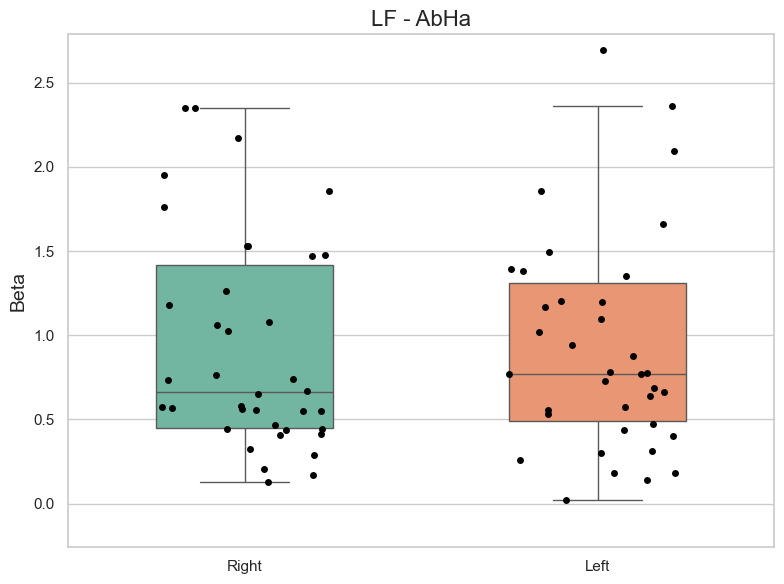

C:\Users\Public\Documents\iSkysoft\CreatorTemp\ipykernel_22136\4167680060.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Hand', y='Beta', data=data, palette='Set2', width=0.5, showfliers=False)


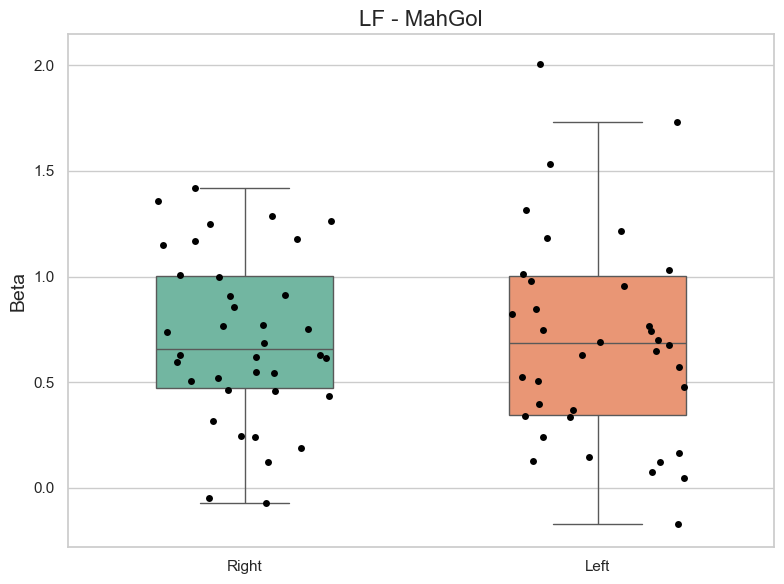

C:\Users\Public\Documents\iSkysoft\CreatorTemp\ipykernel_22136\4167680060.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Hand', y='Beta', data=data, palette='Set2', width=0.5, showfliers=False)


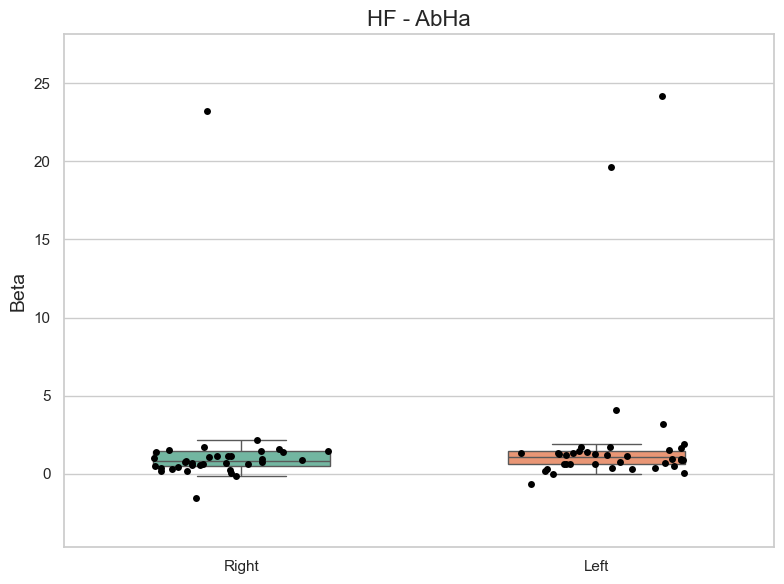

C:\Users\Public\Documents\iSkysoft\CreatorTemp\ipykernel_22136\4167680060.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Hand', y='Beta', data=data, palette='Set2', width=0.5, showfliers=False)


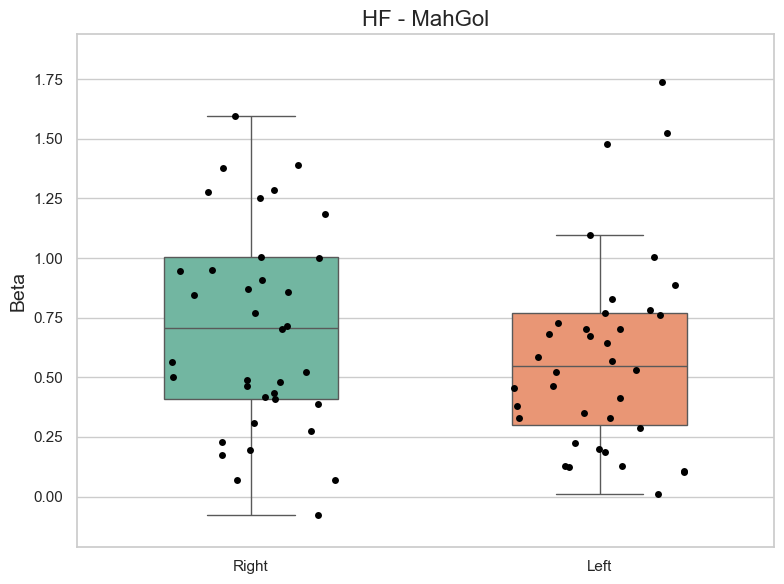

C:\Users\Public\Documents\iSkysoft\CreatorTemp\ipykernel_22136\4167680060.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Hand', y='Beta', data=data, palette='Set2', width=0.5, showfliers=False)


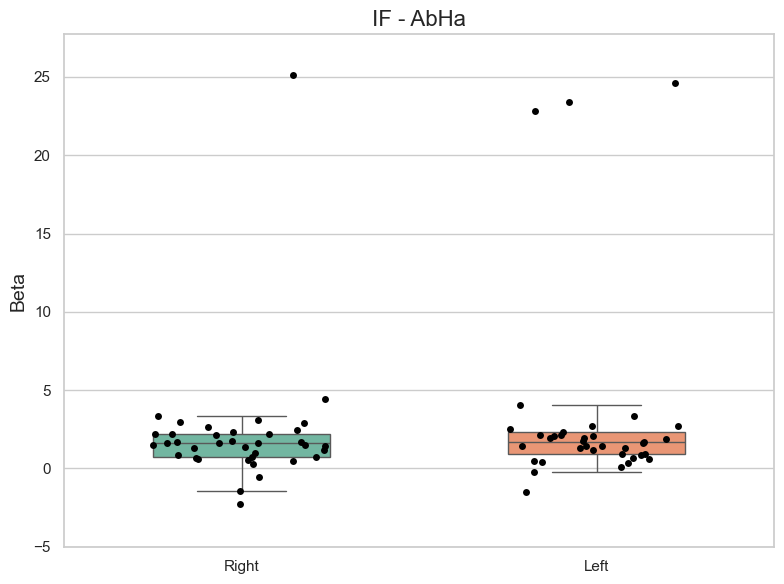

C:\Users\Public\Documents\iSkysoft\CreatorTemp\ipykernel_22136\4167680060.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Hand', y='Beta', data=data, palette='Set2', width=0.5, showfliers=False)


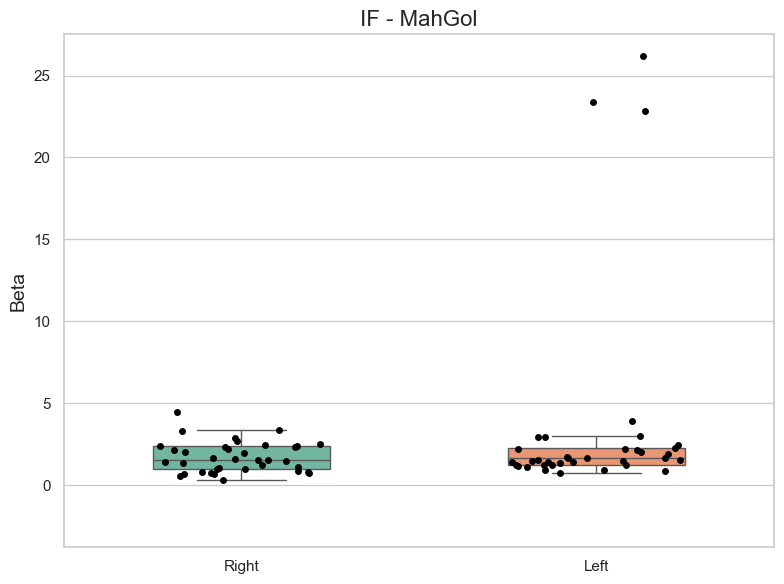

In [42]:
sns.set(style="whitegrid")
frequencies = ['LF', 'HF', 'IF']
pairs = ['AbHa', 'MahGol']
for freq in frequencies:
    for pair in pairs:
        right_col = f"{freq.lower()}_{pair.lower()}_right"
        left_col = f"{freq.lower()}_{pair.lower()}_left"
        right_data = beta_df[right_col]
        left_data = beta_df[left_col]
        valid_mask = right_data.notna() & left_data.notna()
        if valid_mask.sum() == 0:
            continue
        data = pd.DataFrame({
            'Beta': pd.concat([right_data[valid_mask], left_data[valid_mask]]),
            'Hand': ['Right'] * valid_mask.sum() + ['Left'] * valid_mask.sum()
        })
        q_low = data['Beta'].quantile(0.05)
        q_high = data['Beta'].quantile(0.95)
        margin = (q_high - q_low) * 0.2
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='Hand', y='Beta', data=data, palette='Set2', width=0.5, showfliers=False)
        sns.stripplot(x='Hand', y='Beta', data=data, color='black', size=5, jitter=0.25)
        plt.ylim(q_low - margin, q_high + margin)
        plt.title(f"{freq} - {pair}", fontsize=16)
        plt.ylabel('Beta', fontsize=14)
        plt.xlabel('')
        plt.tight_layout()
        plt.show()

In [ ]:
def fit_sigmoid_filtered(data, pair, freq, dom_hand, dom_used=True):
    df = data[
        (data['trialKeys'] == pair) &
        (data['levelFreq'] == freq) &
        (data['blockType'] == 'same')
    ]
    df = df[df['Hand'] == dom_hand] if dom_used else df[df['Hand'] != dom_hand]
    cog_prob = df.groupby(['levelFace', 'srespChoice']).size().unstack(fill_value=0)
    if pair == 'AbHa':
        cog_prob['numer'] = cog_prob.get('Hasan', 0)
        cog_prob['denom'] = cog_prob['numer'] + cog_prob.get('Abbas', 0)
    elif pair == 'MahGol':
        cog_prob['numer'] = cog_prob.get('Goli', 0)
        cog_prob['denom'] = cog_prob['numer'] + cog_prob.get('Mahnaz', 0)
    else:
        raise ValueError("Invalid pair value.")
    cog_prob = cog_prob[cog_prob['denom'] > 0]
    if cog_prob.empty:
        return np.nan
    cog_prob['probability'] = cog_prob['numer'] / cog_prob['denom']
    x_data = cog_prob.index.values
    y_data = cog_prob['probability'].values
    try:
        params, _ = curve_fit(sigmoid, x_data, y_data, p0=[1.0, 1.0], maxfev=5000)
        _, beta = params
        if beta > 10:
            print(f"[INFO] Clipping large beta: {beta:.2f} → 10")
            beta = 10
        return beta
    except Exception as e:
        print(f"[curve_fit FAILED] pair={pair}, freq={freq}, dom_used={dom_used}")
        print("x_data:", x_data)
        print("y_data:", y_data)
        print("Error:", e)
    return np.nan
betas = []
for i in range(1, len(subject)):
    subj_data = subject[i]
    subj_info = sub_info.iloc[i-1]
    hand_map = {'R': 'Right', 'L': 'Left'}
    dom_hand = hand_map.get(subj_info['dom'], None)
    subj_row = {
        'subject_id': f"sub{i}",
        'sex': subj_info['sex'],
        'dom': dom_hand
    }
    for pair in ['AbHa', 'MahGol']:
        for freq in ['LF', 'IF', 'HF']:
            beta_dom = fit_sigmoid_filtered(subj_data, pair, freq, dom_hand, dom_used=True)
            beta_nondom = fit_sigmoid_filtered(subj_data, pair, freq, dom_hand, dom_used=False)
            key_dom = f"{pair.lower()}_{freq.lower()}_dom"
            key_nondom = f"{pair.lower()}_{freq.lower()}_nondom"
            subj_row[key_dom] = beta_dom
            subj_row[key_nondom] = beta_nondom
    betas.append(subj_row)
beta_df = pd.DataFrame(betas)

[INFO] Clipping large beta: 23.19 → 10
[INFO] Clipping large beta: 37.44 → 10
[INFO] Clipping large beta: 20.48 → 10
[INFO] Clipping large beta: 36.40 → 10
[INFO] Clipping large beta: 710.06 → 10


C:\Users\Public\Documents\iSkysoft\CreatorTemp\ipykernel_22136\2454432721.py:2: RuntimeWarning: overflow encountered in exp
  return alpha / (1 + np.exp(-beta * x))
C:\Users\Public\Documents\iSkysoft\CreatorTemp\ipykernel_22136\1808633804.py:24: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(sigmoid, x_data, y_data, p0=[1.0, 1.0], maxfev=5000)


[INFO] Clipping large beta: 23.52 → 10
[INFO] Clipping large beta: 35.69 → 10
[INFO] Clipping large beta: 22.85 → 10
[INFO] Clipping large beta: 23.64 → 10
[INFO] Clipping large beta: 19.62 → 10
[INFO] Clipping large beta: 22.85 → 10
[INFO] Clipping large beta: 24.64 → 10
[INFO] Clipping large beta: 710.06 → 10
[INFO] Clipping large beta: 23.41 → 10


C:\Users\Public\Documents\iSkysoft\CreatorTemp\ipykernel_22136\2454432721.py:2: RuntimeWarning: overflow encountered in exp
  return alpha / (1 + np.exp(-beta * x))
C:\Users\Public\Documents\iSkysoft\CreatorTemp\ipykernel_22136\1808633804.py:24: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(sigmoid, x_data, y_data, p0=[1.0, 1.0], maxfev=5000)


[INFO] Clipping large beta: 26.17 → 10
[INFO] Clipping large beta: 36.88 → 10
[INFO] Clipping large beta: 20.20 → 10
[INFO] Clipping large beta: 25.11 → 10
[INFO] Clipping large beta: 24.16 → 10
[INFO] Clipping large beta: 36.88 → 10
[INFO] Clipping large beta: 36.88 → 10
[INFO] Clipping large beta: 23.41 → 10


In [44]:
beta_df

,subject_id,sex,dom,abha_lf_dom,abha_lf_nondom,abha_if_dom,abha_if_nondom,abha_hf_dom,abha_hf_nondom,mahgol_lf_dom,mahgol_lf_nondom,mahgol_if_dom,mahgol_if_nondom,mahgol_hf_dom,mahgol_hf_nondom
0,sub1,M,Right,1.528752,1.095501,2.223543,1.337508,0.202522,7.844293e-01,1.355446,2.007470,1.394064,1.639541,0.847001,1.095707
1,sub2,M,Right,0.560294,0.300540,0.453792,0.111754,0.032252,1.970127e-01,0.464146,0.646728,2.866069,1.260030,0.068546,0.128196
2,sub3,M,Right,2.353052,2.095724,2.928769,4.077476,10.000000,7.116639e-01,2.513279,1.215675,4.458388,2.142133,0.432920,0.104768
3,sub4,M,Right,0.550385,1.203843,0.734246,0.902702,0.883442,8.942375e-01,1.169001,0.335787,1.530382,0.902021,0.276218,0.107855
4,sub5,M,Right,0.127090,0.023263,-1.429334,-1.531658,-1.533190,8.761447e-08,0.594540,0.630433,3.375264,1.492355,0.488594,0.126171
5,sub6,M,Right,0.437743,0.256669,1.652449,2.095724,10.000000,1.676538e+00,0.549239,0.765496,0.716195,1.429305,0.390202,0.381659
6,sub7,F,Right,1.078493,1.859870,0.974998,1.895094,0.428422,9.723327e-01,1.416660,0.978360,1.243369,1.533172,0.713552,0.463800
7,sub8,F,Right,0.207028,1.350218,1.736930,1.415772,1.595655,1.181799e+00,0.627989,0.394544,2.189863,1.680162,0.944318,0.671447
8,sub9,F,Right,1.062384,2.694909,1.492288,1.975095,-0.165331,-6.653081e-01,0.245320,0.338602,2.340798,1.895161,0.502427,0.770487
9,sub10,F,Right,0.557701,0.183553,0.303374,0.373671,0.692933,8.692495e-01,0.239235,0.241361,0.793704,1.385183,0.176078,0.682255


In [45]:
lf_dom = [wilcoxon(beta_df['abha_lf_dom'], beta_df['abha_lf_nondom']).pvalue, wilcoxon(beta_df['mahgol_lf_dom'], beta_df['mahgol_lf_nondom']).pvalue] 
print("P value for lf freq:", lf_dom[0], lf_dom[1])

P value for lf freq: 0.5659611264854902 0.7633568994206144


In [46]:
hf_dom = [wilcoxon(beta_df['abha_hf_dom'], beta_df['abha_hf_nondom']).pvalue, wilcoxon(beta_df['mahgol_hf_dom'], beta_df['mahgol_hf_nondom']).pvalue] 
print("P value for hf freq:", hf_dom[0], hf_dom[1])

P value for hf freq: 0.7307534597057384 0.421044722374063


In [47]:
if_dom = [wilcoxon(beta_df['abha_if_dom'], beta_df['abha_if_nondom']).pvalue, wilcoxon(beta_df['mahgol_if_dom'], beta_df['mahgol_if_nondom']).pvalue] 
print("P value for if freq:", if_dom[0], if_dom[1])

P value for if freq: 0.3650425070882193 0.8860376867044848


In [48]:
def melt_freq_band(beta_df, freq_band):
    df = beta_df.copy()
    df = df[['subject_id', 'sex', f'abha_{freq_band}_dom', f'abha_{freq_band}_nondom',
             f'mahgol_{freq_band}_dom', f'mahgol_{freq_band}_nondom']]
    df_long = pd.wide_to_long(df.reset_index(),
                              stubnames=[f'abha_{freq_band}', f'mahgol_{freq_band}'],
                              i='subject_id', j='hand_type', sep='_', suffix='.+').reset_index()
    df_long = df_long.rename(columns={
        f'abha_{freq_band}': 'abha',
        f'mahgol_{freq_band}': 'mahgol'
    })
    df_long = pd.melt(df_long, id_vars=['subject_id', 'sex', 'hand_type'],
                      value_vars=['abha', 'mahgol'],
                      var_name='condition', value_name='value')
    return df_long

In [49]:
lf_long = melt_freq_band(beta_df, 'lf')
hf_long = melt_freq_band(beta_df, 'hf')
if_long = melt_freq_band(beta_df, 'if')

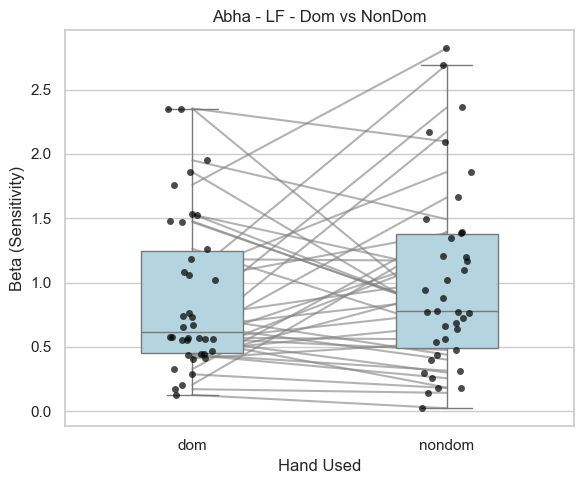

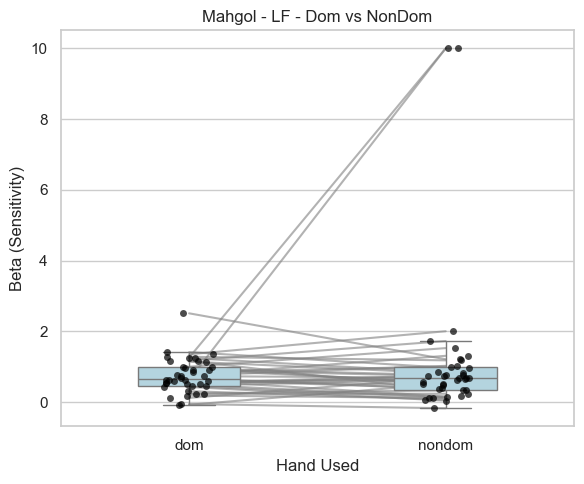

In [ ]:
plot_data = lf_long.copy()
for face_pair in ['abha', 'mahgol']:
    plt.figure(figsize=(6, 5))
    face_df = plot_data[plot_data['condition'] == face_pair]
    for subj_id in face_df['subject_id'].unique():
        d = face_df[face_df['subject_id'] == subj_id]
        d = d.sort_values('hand_type')
        if len(d) == 2:
            plt.plot(['dom', 'nondom'], d['value'].values, color='gray', alpha=0.6)
    sns.boxplot(x='hand_type', y='value', data=face_df, color='lightblue', width=0.4, showfliers=False)
    sns.stripplot(x='hand_type', y='value', data=face_df, color='black', jitter=True, alpha=0.7)
    plt.title(f'{face_pair.capitalize()} - LF - Dom vs NonDom')
    plt.ylabel('Beta (Sensitivity)')
    plt.xlabel('Hand Used')
    plt.tight_layout()
    plt.show()

C:\Users\Public\Documents\iSkysoft\CreatorTemp\ipykernel_22136\4058744470.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(x='condition', y='value', hue='hand_type', data=lf_long,


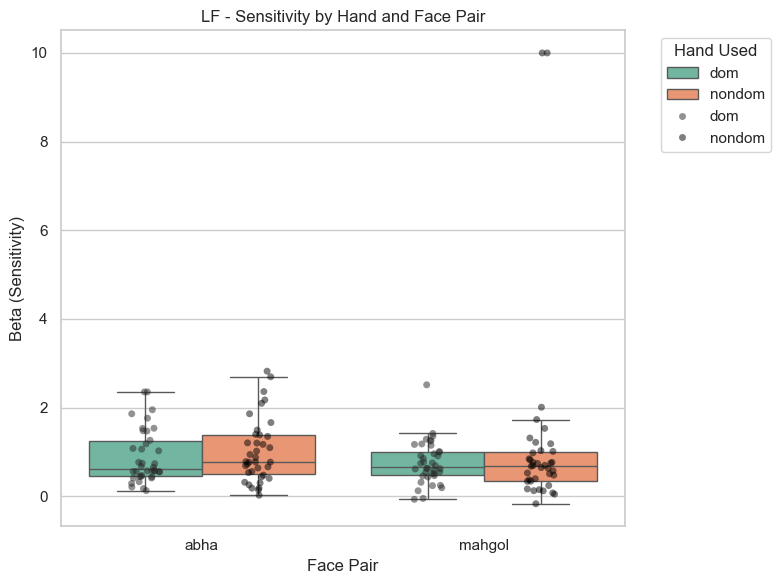

In [51]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='condition', y='value', hue='hand_type', data=lf_long, palette='Set2', showfliers=False)
sns.stripplot(x='condition', y='value', hue='hand_type', data=lf_long,
              dodge=True, jitter=True, color='black', alpha=0.5)
plt.title('LF - Sensitivity by Hand and Face Pair')
plt.ylabel('Beta (Sensitivity)')
plt.xlabel('Face Pair')
plt.legend(title='Hand Used', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

are women better then men?

In [52]:
def fit_sigmoid_basic(data, pair):
    df = data[
        (data['trialKeys'] == pair) &
        (data['blockType'] == 'same')
    ]
    cog_prob = df.groupby(['levelFace', 'srespChoice']).size().unstack(fill_value=0)
    if pair == 'AbHa':
        cog_prob['numer'] = cog_prob.get('Hasan', 0)
        cog_prob['denom'] = cog_prob['numer'] + cog_prob.get('Abbas', 0)
    elif pair == 'MahGol':
        cog_prob['numer'] = cog_prob.get('Goli', 0)
        cog_prob['denom'] = cog_prob['numer'] + cog_prob.get('Mahnaz', 0)
    else:
        raise ValueError("Invalid pair value.")
    cog_prob = cog_prob[cog_prob['denom'] > 0]
    if cog_prob.empty:
        return np.nan
    cog_prob['probability'] = cog_prob['numer'] / cog_prob['denom']
    x_data = cog_prob.index.values
    y_data = cog_prob['probability'].values
    try:
        params, _ = curve_fit(sigmoid, x_data, y_data, p0=[1.0, 1.0], maxfev=5000)
        _, beta = params
        if beta > 10:
            print(f"[INFO] Clipping large beta: {beta:.2f} → 10")
            beta = 10
        return beta
    except Exception as e:
        print(f"[curve_fit FAILED] pair={pair}")
        print("x_data:", x_data)
        print("y_data:", y_data)
        print("Error:", e)
        return np.nan

In [ ]:
betas = []
for i in range(1, len(subject)):
    subj_data = subject[i]
    subj_info = sub_info.iloc[i - 1]
    subj_row = {
        'subject_id': f"sub{i}",
        'sex': subj_info['sex']
    }
    for pair in ['AbHa', 'MahGol']:
        beta = fit_sigmoid_basic(subj_data, pair)
        subj_row[pair.lower()] = beta
    betas.append(subj_row)
beta_df = pd.DataFrame(betas)

In [54]:
beta_df.head()

,subject_id,sex,abha,mahgol
0,sub1,M,1.137710,1.316143
1,sub2,M,0.220283,0.481379
2,sub3,M,2.398223,1.085020
3,sub4,M,0.796341,0.518584
4,sub5,M,-0.295846,0.735381


In [55]:
beta_df

,subject_id,sex,abha,mahgol
0,sub1,M,1.137710,1.316143
1,sub2,M,0.220283,0.481379
2,sub3,M,2.398223,1.085020
3,sub4,M,0.796341,0.518584
4,sub5,M,-0.295846,0.735381
5,sub6,M,0.951597,0.616969
6,sub7,F,0.948375,1.007509
7,sub8,F,1.078368,0.948895
8,sub9,F,0.418150,0.671650
9,sub10,F,0.462633,0.475864


In [56]:
female_abha = beta_df[beta_df['sex'] == 'F']['abha'].dropna()
male_abha = beta_df[beta_df['sex'] == 'M']['abha'].dropna()
female_mahgol = beta_df[beta_df['sex'] == 'F']['mahgol'].dropna()
male_mahgol = beta_df[beta_df['sex'] == 'M']['mahgol'].dropna()
pval_abha = mannwhitneyu(female_abha, male_abha, alternative='two-sided').pvalue
pval_mahgol = mannwhitneyu(female_mahgol, male_mahgol, alternative='two-sided').pvalue
print('P-value for AbHa:', pval_abha)
print('P-value for MahGol:', pval_mahgol)

P-value for AbHa: 0.35261914771518
P-value for MahGol: 0.2792963023532211


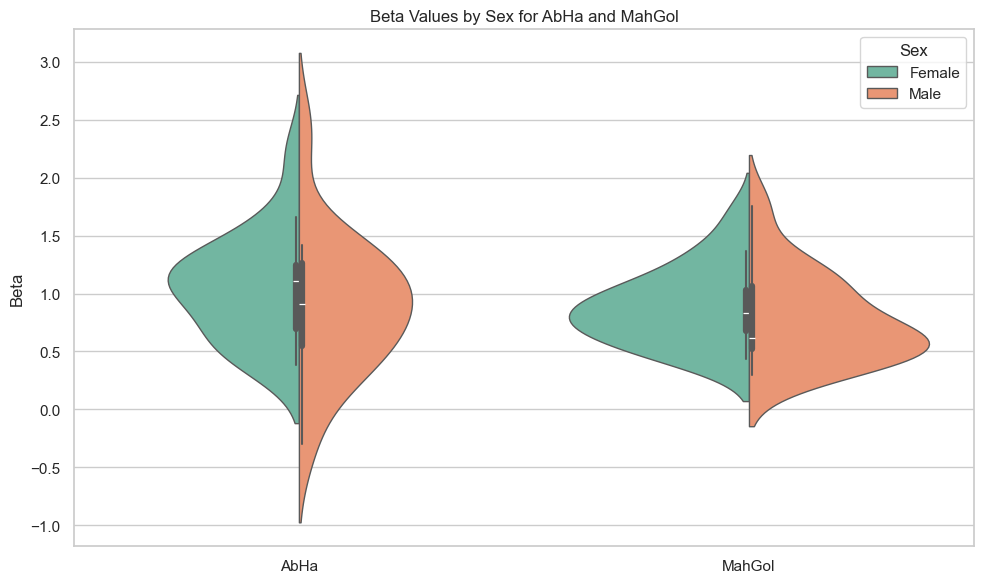

In [57]:
sns.set(style="whitegrid")
abha_data = pd.DataFrame({
    'Beta': pd.concat([female_abha, male_abha]),
    'Sex': ['Female'] * len(female_abha) + ['Male'] * len(male_abha),
    'Pair': ['AbHa'] * (len(female_abha) + len(male_abha))
})
mahgol_data = pd.DataFrame({
    'Beta': pd.concat([female_mahgol, male_mahgol]),
    'Sex': ['Female'] * len(female_mahgol) + ['Male'] * len(male_mahgol),
    'Pair': ['MahGol'] * (len(female_mahgol) + len(male_mahgol))
})
plot_data = pd.concat([abha_data, mahgol_data])
plt.figure(figsize=(10, 6))
sns.violinplot(data=plot_data, x='Pair', y='Beta', hue='Sex', palette='Set2', split=True, inner='box', linewidth=1)
plt.legend(title='Sex')
plt.title('Beta Values by Sex for AbHa and MahGol')
plt.ylabel('Beta')
plt.xlabel('')
plt.tight_layout()
plt.show()